In [12]:
from mpgm.mpgm.evaluation.generating_samples import *
from mpgm.mpgm.models.SPGM import SPGM
import matplotlib.pyplot as plt
import numpy as np
import time

import sympy
import cvxopt
import qpsolvers
import qpoases
from quadprog import solve_qp

from typing import Dict, Optional, Any

from mpgm.mpgm.model_fitters.prox_grad_fitters import Prox_Grad_Fitter, Constrained_Prox_Grad_Fitter
from mpgm.mpgm.model_fitters.prox_operators import QuadProgOperator

import scipy
from functools import partial

In [15]:
gg = RandomNmGraphGenerator(10)
wa = Bimodal_Gaussian_Weight_Assigner(mean_1=-0.1,
                                     std_1=0.02,
                                     mean_2=0.1,
                                     std_2=0.02,
                                     split=0.4)
np.random.seed(0)
    
G = gg.generate_graph(nr_variables=10)
wa.assign_weights(G)
model = TPGM(R=10, theta=G)
sampler = TPGMGibbsSampler(burn_in=50, thinning_nr=150)
    
samples = sampler.generate_samples(model, np.zeros((10, )), 150)

/home/mcio/miniconda3/envs/mpgm/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 22401/22401 [00:16<00:00, 1321.38it/s]


In [18]:
for ii in range(10):
    print(G[ii, ii])

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [19]:
model = SPGM(R=10, R0=5)

nr_variables = 10
theta_init = np.random.normal(0, 0.1, (nr_variables, nr_variables))
np.fill_diagonal(theta_init, 0)

In [20]:
fitter = Prox_Grad_Fitter(alpha=0.8,
                          accelerated=True,
                          save_regularization_paths=False,
                          init_step_size=0.1,
                          early_stop_criterion='likelihood',
                          keep_diags_zero=True)
# a,b,c,d,e = fitter.fit_node(1, model.calculate_nll, model.calculate_grad_nll, samples, theta_init)
ret = fitter.call_fit_node(model.calculate_nll, model.calculate_grad_nll, samples, theta_init, True)

In [14]:
ret[0]

array([[ 0.        ,  0.10512393,  0.03827781,  0.05456828, -0.1073033 ,
         0.13318016, -0.07811968,  0.04228715, -0.01427833,  0.07862503],
       [-0.19721683,  0.        ,  0.17695123, -0.14430664, -0.01101857,
        -0.0058304 , -0.1046673 ,  0.08196438,  0.13215612,  0.04367   ],
       [-0.06462215,  0.05093276,  0.        , -0.12586194, -0.00431448,
        -0.15046155,  0.0262874 ,  0.16411593,  0.04861279,  0.05315851],
       [ 0.05285654,  0.01437931, -0.00282929,  0.        ,  0.12019447,
        -0.15695787, -0.0940718 ,  0.28278044, -0.01407862,  0.01127792],
       [-0.09422409,  0.01040752,  0.13968388, -0.00994232,  0.        ,
        -0.14190954,  0.02278148,  0.11055635,  0.09943622, -0.02261316],
       [ 0.17817387,  0.0591114 , -0.07068593, -0.00951659,  0.06998473,
         0.        , -0.10053354, -0.1067474 ,  0.12477818,  0.07484298],
       [-0.0624096 , -0.02909455,  0.00264242,  0.13361965,  0.01050829,
         0.05054709,  0.        ,  0.01654793

In [21]:
from mpgm.mpgm.evaluation.evaluation_metrics import EvalMetrics

/home/mcio/miniconda3/envs/mpgm/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
EvalMetrics.calculate_MSEs(ret[0], G, EvalMetrics.SymmModes.NONE)

(0.008878978434924977, 0.0)

1071


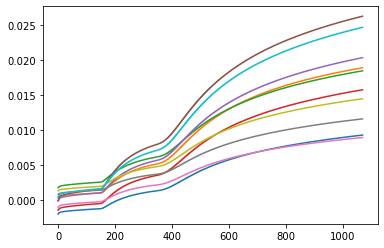

In [16]:
nr_variables = 10
nr_iterations = len(e)
print(nr_iterations)
for ii in range(nr_variables):
    plt.plot(list(range(nr_iterations)), e[:,ii])

In [ ]:
# def solve_constrained_prox_grad_gaines(objective:np.ndarray, data:np.ndarray, reg_param:float):
# Decided not to pursue this, as this is a path regularizer + start parameters are initialised
# using QP anyway.

# The question remains: is QP faster than the path method? (even for small params).

In [37]:
    def prox_operator_cvxopt(data_points:np.ndarray, objective:np.ndarray, reg_parameter:float) -> np.ndarray:
        print('Before: alpha=' + str(reg_parameter) + ' ' + str(objective))
        if True:
            n = len(objective)

            v = objective.reshape((n, 1))
            alpha = reg_parameter
            q = alpha * np.ones((2 * n, 1)) - np.vstack([v, -v])

            # The order of operations is: C -> -C -> (C, -C) -> add one row to it, ensuring positivity of beta aka a
            # row of -1s; d is 2n x 1 of 0s.
            C = data_points
            xC, yC = C.shape
            C = -C  # Since we want our ineq to be greater than or equal to zero.
            G = np.hstack([C, -C])

            # Not sure if this will work.
            G = np.vstack([G, -np.ones((1, 2 * yC))])
            print(G.shape)
            G = Constrained_Prox_Grad_Fitter.remove_dependent_rows(G)
            print(G.shape)
            h = np.zeros((G.shape[0], 1))

            P = np.zeros((2 * n, 2 * n))
            P[0:n, 0:n] = np.identity(n)
            P[n:2 * n, 0:n] = -np.identity(n)
            P[0:n, n:2 * n] = -np.identity(n)
            P[n:2 * n, n:2 * n] = np.identity(n)

            P = cvxopt.matrix(P, tc='d')
            q = cvxopt.matrix(q, tc='d')
            G = cvxopt.matrix(G, tc='d')
            h = cvxopt.matrix(h, tc='d')
            solution = cvxopt.solvers.qp(P, q, G, h, kktsolver='ldl', options={'kktreg': 1e-9, 'show_progress': False,
                                                                               'maxiters': 500})

            beta_2n = np.array(solution['x']).reshape((2 * n,))
            beta = beta_2n[:n] - beta_2n[n:]

            print("After: " + str(beta))
            print("Status: " + str(solution['status'] + ' ' + str(solution['iterations'])))
            return beta, beta_2n

In [44]:
objective = np.zeros((10, ))
objective[0] = 1
beta = prox_operator_osqp(samples, objective, reg_parameter=1)
print(beta2n)
print(beta)

Before: alpha=1 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(151, 20)
(11, 20)
[ 5.00000000e-01 -3.79999785e-11  3.18380733e-10 -3.81704800e-11
 -3.81704800e-11  3.18380733e-10 -1.46282057e-10 -2.74406034e-10
  3.18380733e-10 -3.81704800e-11 -5.00000000e-01 -3.79999785e-11
  3.18380656e-10 -3.81704589e-11 -3.81704589e-11  3.18380656e-10
 -1.46281976e-10 -2.74406008e-10  3.18380656e-10 -3.81704589e-11]
After: [ 1.00000000e+00 -1.35063084e-24  7.65391635e-17 -2.10893120e-17
 -2.10893120e-17  7.65391635e-17 -8.11976728e-17 -2.56868783e-17
  7.65391635e-17 -2.10893120e-17]
[ 4.99999696e-01  5.00875265e-05  4.22656237e-05  9.09708869e-05
  9.08869620e-05  1.09170270e-04  2.88633653e-05  4.65018566e-05
  1.32797981e-04  8.63086549e-05 -5.00000317e-01 -4.72001852e-05
 -4.29568727e-05 -9.06854880e-05 -9.15920369e-05 -1.06790862e-04
 -2.92343618e-05 -4.58984725e-05 -1.34387143e-04 -8.84836743e-05]
(array([ 1.00000000e+00, -1.35063084e-24,  7.65391635e-17, -2.10893120e-17,
       -2.10893120e-17,  7.6539163

/home/mcio/miniconda3/envs/mpgm/lib/python3.8/site-packages/qpsolvers/osqp_.py:101: UserWarning: Converted P to scipy.sparse.csc.csc_matrix
For best performance, build P as a csc_matrix rather than as a numpy.ndarray
  warn(conversion_warning("P"))
/home/mcio/miniconda3/envs/mpgm/lib/python3.8/site-packages/qpsolvers/osqp_.py:122: UserWarning: Converted G to scipy.sparse.csc.csc_matrix
For best performance, build G as a csc_matrix rather than as a numpy.ndarray
  warn(conversion_warning("G"))


In [39]:
def prox_operator_quadprog(data_points:np.ndarray, objective:np.ndarray, reg_parameter:float) -> np.ndarray:
    print('Before: alpha=' + str(reg_parameter) + ' ' + str(objective))
    if True:
        n = len(objective)

        v = objective.reshape((n, 1))
        alpha = reg_parameter
        q = alpha * np.ones((2*n, 1)) - np.vstack([v, -v])
        q = q.reshape((2*n, ))

        # The order of operations is: C -> -C -> (C, -C) -> add one row to it, ensuring positivity of beta aka a
        # row of -1s; d is 2n x 1 of 0s.
        C = data_points
        xC, yC = C.shape
        G = np.hstack([C, -C])

        # Not sure if this will work.
        G = np.vstack([G, np.ones((1, 2 * yC))])
        G = Constrained_Prox_Grad_Fitter.remove_dependent_rows(G)
        h = np.zeros((G.shape[0],))

        P = np.zeros((2*n, 2*n))
        P[0:n, 0:n] = np.identity(n)
        P[n:2*n, 0:n] = -np.identity(n)
        P[0:n, n:2*n] = -np.identity(n)
        P[n:2*n, n:2*n] = np.identity(n)

        print(G.shape)
        solution = solve_qp(P, -q, G.T, h)
        print(solution)

        beta_2n = np.array(solution['x']).reshape((2 * n,))
        beta = beta_2n[:n] - beta_2n[n:]

        print("After: " + str(beta))
        print("Status: " + str(solution['status'] + ' ' + str(solution['iterations'])))
        return beta 


In [16]:
def prox_operator_qpoases(data_points:np.ndarray, objective:np.ndarray, reg_parameter:float) -> np.ndarray:
    print('Before: alpha=' + str(reg_parameter) + ' ' + str(objective))
    if True:
        n = len(objective)

        v = objective.reshape((n, 1))
        alpha = reg_parameter

        q = alpha * np.ones((2*n, 1)) - np.vstack([v, -v])
        q = q.reshape((2*n, ))

        # The order of operations is: C -> -C -> (C, -C) -> add one row to it, ensuring positivity of beta aka a
        # row of -1s; d is 2n x 1 of 0s.
        C = data_points
        xC, yC = C.shape
        C = -C  # Since we want our ineq to be greater than or equal to zero.
        G = np.hstack([C, -C])

        # Not sure if this will work.
        G = np.vstack([G, -np.identity(2*yC)])
        print(G.shape)
#         G = QuadProgOperator.remove_dependent_rows(G)
#         print(G.shape)
        h = np.zeros((G.shape[0], ))

        P = np.zeros((2 * n, 2 * n))
        P[0:n, 0:n] = np.identity(n)
        P[n:2 * n, 0:n] = -np.identity(n)
        P[0:n, n:2 * n] = -np.identity(n)
        P[n:2 * n, n:2 * n] = np.identity(n)
        
        solution = qpsolvers.qpoases_solve_qp(P, q, G, h)
        print(solution)

        beta_2n = solution.reshape((2 * n,))
        beta = beta_2n[:n] - beta_2n[n:]

        print("After: " + str(beta))
        return beta, beta_2n

In [12]:
def prox_operator_osqp(data_points:np.ndarray, objective:np.ndarray, reg_parameter:float) -> np.ndarray:
    print('Before: alpha=' + str(reg_parameter) + ' ' + str(objective))
    if True:
        n = len(objective)

        v = objective.reshape((n, 1))
        alpha = reg_parameter

        q = alpha * np.ones((2*n, 1)) - np.vstack([v, -v])
        q = q.reshape((2*n, ))

        # The order of operations is: C -> -C -> (C, -C) -> add one row to it, ensuring positivity of beta aka a
        # row of -1s; d is 2n x 1 of 0s.
        C = data_points
        xC, yC = C.shape
        C = -C  # Since we want our ineq to be greater than or equal to zero.
        G = np.hstack([C, -C])

        # Not sure if this will work.
        G = np.vstack([G, -np.identity(2*yC)])
        print(G.shape)
#         G = Constrained_Prox_Grad_Fitter.remove_dependent_rows(G)
#         print(G.shape)
        h = np.zeros((G.shape[0], ))

        P = np.zeros((2*n, 2*n))
        P[0:n, 0:n] = np.identity(n)
        P[n:2 * n, 0:n] = -np.identity(n)
        P[0:n, n:2 * n] = -np.identity(n)
        P[n:2 * n, n:2 * n] = np.identity(n)
        
        solution = qpsolvers.osqp_solve_qp(P, q, G, h)
        print(solution)

        beta_2n = solution.reshape((2 * n,))
        beta = beta_2n[:n] - beta_2n[n:]

        print("After: " + str(beta))
        return beta, beta_2n

In [11]:
np.identity(3)

/home/mcio/miniconda3/envs/mpgm/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [17]:
objective = np.zeros((10, ))
objective[0] = 1
beta, beta2n = prox_operator_qpoases(samples, objective, reg_parameter=2)
print(beta2n)
print(beta)

Before: alpha=2 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(170, 20)
[-4.77395901e-15 -4.88498131e-15 -4.88498131e-15 -4.88498131e-15
 -4.88498131e-15 -4.88498131e-15 -4.88498131e-15 -4.88498131e-15
 -4.88498131e-15 -4.88498131e-15 -4.88498131e-15 -4.88498131e-15
 -4.88498131e-15 -4.88498131e-15 -4.99600361e-15 -4.99600361e-15
 -4.99600361e-15 -4.99600361e-15 -4.99600361e-15 -4.99600361e-15]
After: [1.11022302e-16 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.11022302e-16 1.11022302e-16 1.11022302e-16 1.11022302e-16
 1.11022302e-16 1.11022302e-16]
[-4.77395901e-15 -4.88498131e-15 -4.88498131e-15 -4.88498131e-15
 -4.88498131e-15 -4.88498131e-15 -4.88498131e-15 -4.88498131e-15
 -4.88498131e-15 -4.88498131e-15 -4.88498131e-15 -4.88498131e-15
 -4.88498131e-15 -4.88498131e-15 -4.99600361e-15 -4.99600361e-15
 -4.99600361e-15 -4.99600361e-15 -4.99600361e-15 -4.99600361e-15]
[1.11022302e-16 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.11022302e-16 1.11022302e-16 1.11022302e-16 1.11022302e-16
 1.1102

In [12]:
# Need to write + test a projection operator onto the intersection of halfspaces.
# scipy.optimize.minimize? How fast is it?
def l2norm(x:np.ndarray, objective:np.ndarray, reg_param:float) -> float:
    sq_norm = (x-objective)**2
    return np.sum(sq_norm) * 1/(2 * reg_param)

def jac_l2norm(x:np.ndarray, objective:np.ndarray, reg_param:float) -> np.ndarray:
    return (x-objective)/reg_param

# def constraint(x:np.ndarray, data_point:np.ndarray, node):
#     inequality_lh = np.dot(x, data_point) - x[node] * data_point[node] + x[node]
#     return inequality_lh >= 0

# def constraint_jac(x:np.ndarray, data_point:np.ndarray, node:int) -> np.ndarray:
#     jac = np.array(data_point)
#     jac[node] = 1
#     return jac

# def construct_constraints(data:np.ndarray, node:int) -> Dict[Any, Any]:
#     dict_seq = []
#     reduced_data = Constrained_Prox_Grad_Fitter.remove_dependent_rows(data)
#     for ii in range(reduced_data.shape[0]):
#         data_point = reduced_data[ii, :]
#         constraint_dict = dict()
#         constraint_dict['type'] = 'ineq'
#         constraint_dict['fun'] = partial(constraint, data_point=data_point, node=node)
#         constraint_dict['jac'] = partial(constraint_jac, data_point=data_point, node=node)
#         dict_seq.append(constraint_dict)
#     return dict_seq

def construct_constraints(data:np.ndarray, node:int):
    A = np.copy(data)
    A[:, node] = 1
    constraints = scipy.optimize.LinearConstraint(A, 0, np.inf, keep_feasible=False)
    return constraints

def soft_thresholding_operator(objective:np.ndarray, reg_parameter:float) -> np.ndarray:
    obj_plus = objective - reg_parameter
    obj_minus = objective + reg_parameter
    return obj_plus * (obj_plus > 0) + obj_minus * (obj_minus < 0)

# Disagree with this.
def check_convergence(x:np.ndarray, z:np.ndarray, threshold:Optional[float]=1e-3):
    converged_params = (x - z) ** 2 <= (threshold ** 2) * (x ** 2)
    all_converged = all(converged_params)
    return all_converged

In [34]:
def prox_operator_admm(data_points:np.ndarray, 
                       objective:np.ndarray, 
                       reg_parameter:float, 
                       node:int, 
                       tau:Optional[float]=0.1,
                       min_iter:Optional[int]=100,
                       max_iter:Optional[int]=1000) -> np.ndarray:
    n = len(objective)
    u = np.zeros((n,))
    z = np.copy(objective)
    x = np.copy(objective)
    
    new_reg_parameter = reg_parameter/(1+tau)
    
    f_operator = partial(soft_thresholding_operator, 
                         reg_parameter=new_reg_parameter)
    
    # Need to specify: x0, jac and fun.
    g_operator = partial(scipy.optimize.minimize, 
                         method="SLSQP",
                         constraints=construct_constraints(data_points, node))
    
    # Found bug: this flavor of ADMM makes x converge to -z. 
    # Since z is the result of g_operator, keeping constraints true for x, means
    # multiplying them by -1 to keep them true for z (if it makes sense).
    
    # STOOOPID.
    
    iteration = 0
    while (iteration <= min_iter or not check_convergence(x, z)) and iteration <= max_iter:
        print(iteration)
        
        prior_lasso_objective = (objective + tau*(z-u))/(1+tau)
        
        print(prior_lasso_objective)
        
        x = f_operator(prior_lasso_objective)
        
        fun = partial(l2norm, objective=x+u, reg_param=1.0)
        jac = partial(jac_l2norm, objective=x+u, reg_param=1.0)
        z = g_operator(x0=(x+u), fun=fun, jac=jac)['x']
        
        u = u + x - z
        
        iteration += 1
        
        print(x)
        print(z)
    
    return x, z

In [35]:
objective = np.random.normal(0, 0.1, (10, ))
objective

array([ 0.09159103,  0.17134248, -0.05552142, -0.03294018,  0.07096982,
       -0.09134358,  0.05778199, -0.09372446, -0.19629298, -0.03809065])

In [36]:
x, z = prox_operator_admm(data_points=samples,
                      objective=objective,
                      reg_parameter=0.01,
                      node=0,
                      max_iter=100)

0
[ 0.09159103  0.17134248 -0.05552142 -0.03294018  0.07096982 -0.09134358
  0.05778199 -0.09372446 -0.19629298 -0.03809065]
[ 0.08250012  0.16225158 -0.04643051 -0.02384927  0.06187891 -0.08225267
  0.04869108 -0.08463355 -0.18720207 -0.02899974]
[ 0.0332503   0.0499647  -0.04643051 -0.06452985  0.05212405 -0.12293324
  0.00431869 -0.08463355 -0.18720207 -0.03756898]
1
[ 0.08181007  0.15010024 -0.05469497 -0.0395102   0.06836976 -0.0979136
  0.04888783 -0.09289801 -0.19546653 -0.03882224]
[ 0.07271916  0.14100933 -0.04560406 -0.0304193   0.05927885 -0.08882269
  0.03979692 -0.0838071  -0.18637562 -0.02973134]
[ 0.0328032   0.0495989  -0.04560406 -0.06348663  0.05148728 -0.12189003
  0.00377675 -0.0838071  -0.18637562 -0.03657996]
2
[ 0.0781407   0.14175695 -0.05461984 -0.04242149  0.06760355 -0.10082488
  0.04556401 -0.09282288 -0.1953914  -0.03935493]
[ 0.06904979  0.13266604 -0.04552893 -0.03333058  0.05851264 -0.09173397
  0.0364731  -0.08373197 -0.18630049 -0.03026403]
[ 0.0327625

In [82]:
x

array([-23.79052454, -23.72687537, -24.0426352 , -23.97635005,
       -23.79407879, -23.52850209, -23.72689923, -23.61790807,
       -23.93272802, -23.54318791])

In [1]:
z

NameError: name 'z' is not defined

In [84]:
x + z

array([-1.42108547e-14, -3.55271368e-15,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  3.55271368e-15,  3.55271368e-15,  0.00000000e+00,
       -3.55271368e-15, -3.55271368e-15])

In [5]:
from scipy.optimize import linprog
import numpy as np

c = np.zeros(6)
c[5] = 1
A = np.array([[1, 2, 7, 2, 4],
             [0, 0, 9, 6, 2],
             [7, 9, 4, 5, 3],
             [1, 4, 0, 7, 9],
             [9, 7, 3, 8, 3]])
A_ub = np.hstack((A, -np.ones((5,1))))
b_ub = np.zeros(5)

A_eq = np.ones((1, 6))
A_eq[0, 5] = 0
b_eq = np.ones(1)

# Default bounds are (0, None).
x = linprog(c, A_ub, b_ub, A_eq, b_eq)
print(x)

     con: array([-1.1925998e-09])
     fun: 4.317073170051477
 message: 'Optimization terminated successfully.'
     nit: 6
   slack: array([-4.27055857e-09,  4.79674792e-01,  1.13821130e-01, -4.76381336e-09,
       -8.41605430e-09])
  status: 0
 success: True
       x: array([2.19512195e-01, 2.48451964e-10, 3.25203252e-01, 2.44575918e-10,
       4.55284553e-01, 4.31707317e+00])


In [2]:
import numpy as np

In [4]:
def prox(objective: np.ndarray, reg_parameter: float, node: int, data_points: np.ndarray) -> np.ndarray:
    obj_plus = objective - reg_parameter
    obj_minus = objective + reg_parameter
    return obj_plus * (obj_plus > 0) + obj_minus * (obj_minus < 0)

In [6]:
s = np.array([0.5, 0.6, 0.7, 1])
print(prox(s, 0.6, 0, np.array([])))

[0.  0.  0.1 0.4]


In [8]:
L = np.identity(10)

In [9]:
L[9,0] = 1
L[8,3] = 1

In [10]:
L

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [11]:
L * L.T

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [13]:
from sklearn.datasets import make_sparse_spd_matrix

In [29]:
A = make_sparse_spd_matrix(dim=10,
                          alpha=0.9,
                          norm_diag=False,
                          smallest_coef=0.1,
                          largest_coef=0.1)

In [30]:
print(A)

[[ 1.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    1.02  0.    0.    0.    0.    0.    0.   -0.1  -0.1 ]
 [ 0.    0.    1.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    1.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    1.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    1.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    1.01 -0.1   0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.   -0.1   1.    0.    0.  ]
 [ 0.   -0.1   0.    0.    0.    0.    0.    0.    1.    0.  ]
 [ 0.   -0.1   0.    0.    0.    0.    0.    0.    0.    1.  ]]
